# Graph Anomaly Detection


## Loading and preparing the data

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle as pkl

In [2]:
# Read files
path = "./dades_marti/"
df_classes = pd.read_csv(path + "elliptic_txs_classes.csv") # Nodes' labels
df_edges = pd.read_csv(path + "elliptic_txs_edgelist.csv") # Edges
df_features = pd.read_csv(path + "elliptic_txs_features.csv", header=None) # Nodes' features

In [3]:
# Change column names of df_features
colNames1 = {'0': 'txId', 1: "Time Step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

df_features = df_features.rename(columns=colNames)

In [4]:
# Pass unknown to number -1, 1 ilicit, 0 licit
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = -1
df_classes.loc[df_classes['class'] == '2', 'class'] = 0
df_classes.loc[df_classes['class'] == '1', 'class'] = 1

# Time step now starts at 0
df_features['Time Step'] -= 1

print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edges.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


In [5]:
# Merge Class and features
df_class_feature = pd.merge(df_classes, df_features)
# df_class_feature.head()
df = df_class_feature
del df_class_feature
df.head()

,txId,class,Time Step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,-1,0,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,-1,0,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,-1,0,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,0,0,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,-1,0,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


## Single out a time step and work with

#### Study timestep properties

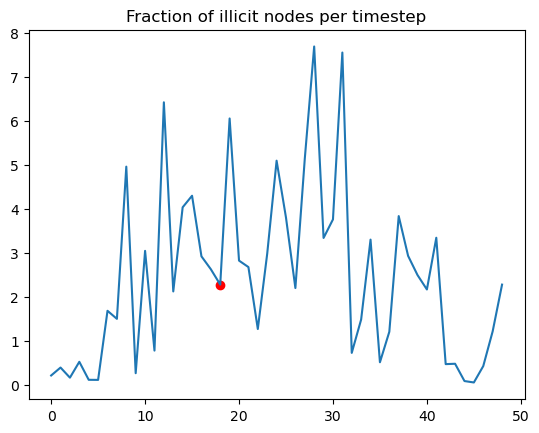

Median proportion highlighted in red


In [6]:
# Illicit node proportion

proportions = []
for i in range(0, 49):
    class_vector = df[df['Time Step'] == i]['class']
    illicit_count = len([classe for classe in class_vector if classe == 1])
    proportions.append(100*illicit_count / len(class_vector))

# Get the index of the median
median_index = np.argsort(proportions)[len(proportions)//2]

# Plot the proportions of illicit nodes
plt.plot(proportions)
plt.scatter(median_index, proportions[median_index], color='red')
plt.title('Fraction of illicit nodes per timestep')
plt.show()

print('Median proportion highlighted in red')

#### Study timestep 18

I picked 18 because it's the median proportion but it's pretty arbitrary; it doesn't matter.

In [7]:
# Separate this timestep's rows from the df's
df18 = df[df['Time Step'] == 18]
df18_edges = df_edges[df_edges['txId1'].isin(df18['txId']) & df_edges['txId2'].isin(df18['txId'])]

# Version of the df for machine learning
df18_ml = df18.drop(columns=['txId', 'class', 'Time Step'])

len(df18), len(df18_edges)

(3506, 3838)

In [8]:
# Create graph from the df of edges
edgelist = [(r['txId1'], r['txId2']) for i, r in df18_edges.iterrows()]
G18 = nx.Graph(edgelist)

G18.order(), G18.size()

(3506, 3838)

In [9]:
# Data
print("Nº of illicit nodes:", len(df18[df18['class'] == 1]))
print("Nº of licit nodes:", len(df18[df18['class'] == 0]))
print("Nº of unknown nodes:", len(df18[df18['class'] == -1]))

Nº of illicit nodes: 80
Nº of licit nodes: 665
Nº of unknown nodes: 2761


#### Node2Vec

In [10]:
# node2vec embeddings?
from node2vec import Node2Vec
import tqdm as notebook_tqdm
from gensim.models import Word2Vec

train = False
if train:
    node2vec = Node2Vec(G18, dimensions=5, walk_length=30, num_walks=200, p=2, q=1, workers=1)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    model.save("./dades_marti/node2vec_ts18.bin")

In [11]:
model = Word2Vec.load('dades_marti/node2vec_ts18.bin')

# Access the embedding weights
embeddings = model.wv.vectors

# Check the shape of the embedding matrix
print("Shape of embedding matrix:", embeddings.shape)

Shape of embedding matrix: (3506, 5)


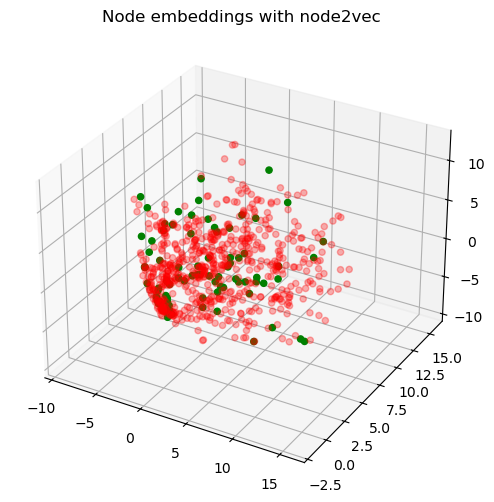

In [12]:
# Plot 3D embeddings

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# Color code by classes
colours = ['yellow', 'red', 'green']
alphas = [0, 0.3, 1]

for label in np.unique(df18['class']):
    indices = np.where(df18['class'] == label)
    ax.scatter(embeddings[indices, 0],
               embeddings[indices, 1],
               embeddings[indices, 2],
               c=colours[label+1],
               label=f'Class {label}',
               alpha=alphas[label+1])
    
plt.title("Node embeddings with node2vec")
plt.show()

# Una altra opcio es tsne, per reduir dimensionalitat i plotejar


Now we try to do machine learning with these embeddings to see if we're able to obtain similar results than with the initial features


Explained variance ratio: 0.9994219371215846
Data reduction, from shape (3506, 167) to (3506, 100)

Training Random forest...

Testing Random forest...

Accuracy: 98.00%
Precision: 100.00%
Recall: 83.00%
F1 Score: 91.00%


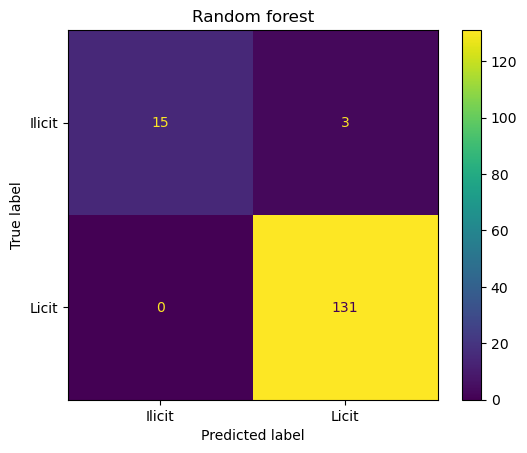

In [13]:
from mLearning import machineLearning

method = "Random forest"

# First, with the original dataframe
df_training = machineLearning(df18)
applied_PCA = df_training.apply_PCA(ncomponents=100)
df_training.train_and_test(method, display_conf_matrix=True, modeMarti=True)


Training Random forest...

Testing Random forest...

Accuracy: 87.00%
Precision: 0.00%
Recall: 0.00%
F1 Score: 0.00%


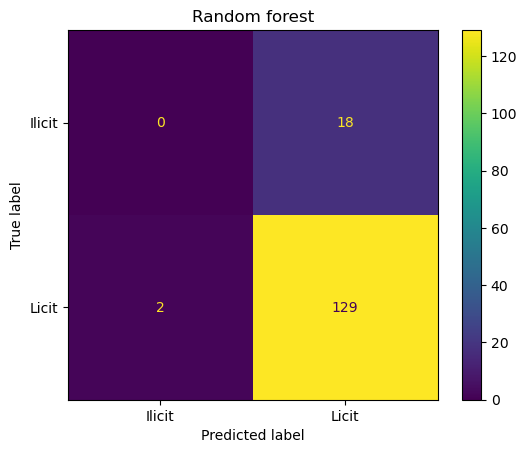

In [14]:
# Then, with a node2vec dataframe

# Create a DataFrame for the principal components
columns = [f"n2v_{i+1}" for i in range(embeddings.shape[1])]
n2v_df = pd.DataFrame(data=embeddings, columns=columns)

n2v_df['class'] = list(df18['class'])
n2v_df['txId'] = list(df18['txId'])

df_training = machineLearning(n2v_df)
df_training.train_and_test(method, use_pca=False, display_conf_matrix=True, modeMarti=True)


Compared to the performance of the classifier with the original features, we can see that the node2vec embeddings with only 5 dimensions are not useful. We will try if for some number of dimensions we can get better results.

In [15]:
# For up to 128 (2^7) embedding dimensions
train_this = False
if train_this:
    results = {}
    for i in range(2, 8):
        print(f"\nIteration {i-1}, trying embeddings of {2**i} dimensions")
        emb_dim = 2**i
        # Node2Vec training
        node2vec = Node2Vec(G18, dimensions=emb_dim, walk_length=30, num_walks=200, p=2, q=1, workers=1)
        model = node2vec.fit(window=10, min_count=1, batch_words=4)
        model.save(f"./dades_marti/ts18_n2v_{emb_dim}.bin")

        # Create the dataset
        embeddings = model.wv.vectors
        columns = [f"n2v_{i+1}" for i in range(embeddings.shape[1])]
        n2v_df = pd.DataFrame(data=embeddings, columns=columns)
        # Add pertinent vectors
        n2v_df['class'] = list(df18['class'])
        n2v_df['txId'] = list(df18['txId'])
        
        df_training = machineLearning(n2v_df)
        df_training.train_and_test(method, use_pca=False, display_conf_matrix=True, modeMarti=True)
        # Aim for a good f1 score and set >0.75 as a boundary
        this_iterations_results = df_training.get_results()
        this_iterations_results = list(this_iterations_results.iloc[-1])
        results[2**i] = this_iterations_results
        if results[2**i][-1] >= 0.75:
            break 


In [16]:
a = {'a': [0,1,2,3,4,5,6], 'b':[6,5,4,3,2,1,0]}
# a = pd.DataFrame(a)
a['a'][-1]

6

#### Cluster-then-label

In [17]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *

import random
from collections import Counter
from icecream import ic

In [18]:
# Cluster-then label?

X_train, X_test, y_train, y_test = train_test_split(df18_ml, df18['class'])

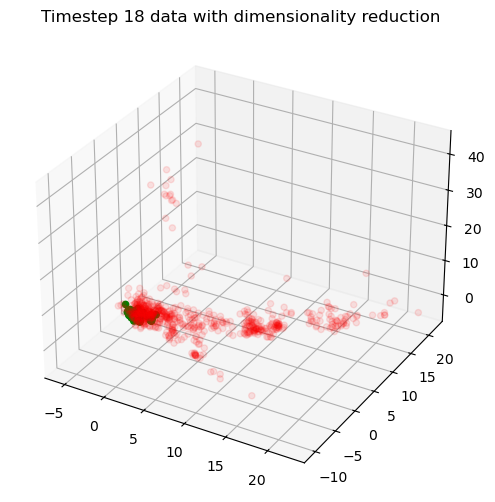

In [19]:
# Standarize features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df18_ml)

# Apply PCA
pca = PCA(n_components=80)  # You can choose the number of components you want to keep
principal_components = pca.fit_transform(scaled_data)

# Visualize

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# Color code by classes
colours = ['yellow', 'red', 'green']
alphas = [0, 0.1, 1]

for label in np.unique(df18['class']):
    indices = np.where(df18['class'] == label)
    ax.scatter(principal_components[indices, 0],
               principal_components[indices, 1],
               principal_components[indices, 2],
               c=colours[label+1],
               label=f'Class {label}',
               alpha=alphas[label+1])
    
plt.title("Timestep 18 data with dimensionality reduction")
plt.show() 


In [69]:
class Cluster_Then_Label():
    def __init__(self, df, classes, n_clusters=8, random_state=2003):
        # Standarize data (np array)
        self.data = StandardScaler().fit_transform(df)
        # Class labels
        self.y = np.array(classes)
        self.y_original = self.y.copy()
        # Indices
        self.df_indices = df.index.tolist()
        self.indices = np.arange(0, len(self.y))
        # Train test split saving the indices
        if random_state is None:
            random_state = random.randint(0,100000)
        self.random_state = random_state
        self.train_indices, self.test_indices = \
            train_test_split(self.indices, test_size=0.2, random_state=self.random_state)
        # Unlabelling the test datapoints
        self.ground_truth_train = np.array([-1 if self.indices[i] in self.test_indices else label for i, label in enumerate(self.y)])
        print(self.ground_truth_train)
        # Empty array for the kmeans predictions
        # Number of k-means clusters
        self.k = n_clusters
        # Other array initializations
        self.y_pred = np.empty(0)
        self.purities = [0]*self.k # Array [0,0,0...]
        self.idx = {}
        self.kmeans = None

    def run_kmeans(self):
        # print(f"Run KMeans with {self.k} clusters.")
        self.kmeans = KMeans(n_clusters=self.k, n_init='auto', verbose=0).fit(self.data)       
    
    def get_purities(self):
        # print("Find purities")
        purities = [0]*self.k
        # Predicted cluster labels
        self.y_pred = np.array(self.kmeans.labels_)
        cluster_labels = np.unique(self.y_pred)
        # For each cluster label
        for cluster_label in cluster_labels:
            # Get the indices of data points in the cluster
            self.idx[cluster_label] = np.where(self.y_pred == cluster_label)[0]
            # Discard labels in the train set as unknown
            cluster_labels_true = self.ground_truth_train[self.idx[cluster_label]] # [-1 -1 1 -1 1 1]
            # Find the majority and minority class in the cluster
            counts = Counter(cluster_labels_true) #.most_common(1)[0][1]
            # Add 0 values to avoid errors
            if list(counts.keys()) == [-1]:
                counts[0] = 0
                counts[1] = 0
            clean_counts = counts.copy()
            # Drop -1 values because we don't care about them
            if -1 in list(clean_counts.keys()):
                del clean_counts[-1]
            # Save the max class as well as the counts
            max_count = max(counts[0], counts[1]) # maximum between class 0 and class 1
            max_class = list(counts.keys())[list(counts.values()).index(max_count)]
            min_count = min(counts[0], counts[1])
            # Save the majority labelled class and its purity for each cluster
            # Add a small number to avoid division by zero error
            purities[cluster_label] = (max_class, max_count/(max_count+min_count+1e-10))
        self.purities = purities 
    
    def loop(self, n_iters=5):
        # Create counter of conversions
        conversions = [0, 0]
        for iter in range(n_iters):
            # Array to save from which cluster we want to substitute unknowns and to which value
            # [(cluster_label, class_label)]
            substitute = []
            # Run k means and obtain the purities for each cluster
            self.run_kmeans()
            self.get_purities()
            # For each cluster, if 85% of labeled nodes are of the same class, save the label and the class
            for c_label in range(len(self.purities)):
                if self.purities[c_label][1] > 0.85:
                    substitute.append((c_label, self.purities[c_label][0]))
            # If no cluster filled the condition, end this iteration
            if len(substitute) == 0:
                break
            # For each cluster and label, substitute from ground_truth_train the unknown nodes by their 
            # new labels. Also, count when this happens for label 0 and when for label 1.
            for cluster_index, label in substitute:
                slice = self.y[self.idx[cluster_index]]
                slice[slice == -1] = label
                self.y[self.idx[cluster_index]] = slice
                conversions[label] += 1
        # print(substitute)
        # print(self.purities, iter)
        print(f"After {iter+1} iterations:\n- {conversions[0]} nodes were pseudo-labelled as 0.\n- {conversions[1]} node(s) were pseudo labelled as 1.\n")

    def test(self, show=True):
        # Separate into train and test
        _, y_val, _, y_pred = train_test_split(self.y_original, self.y, test_size=0.2, random_state=self.random_state)
        # # Model evaluation metrics
        # print(f"Testing...\n")
        # # accuracy = round(accuracy_score(y_test, y_pred), 2)
        # # print("Accuracy: {:.2f}%".format(accuracy * 100))
        # precision = round(precision_score(y_test, y_pred, pos_label=1), 2)
        # print("Precision: {:.2f}%".format(precision * 100))
        # recall = round(recall_score(y_test, y_pred, pos_label=1), 2)
        # print("Recall: {:.2f}%".format(recall * 100))
        # f1 = round(f1_score(y_test, y_pred, pos_label=1),2)
        # print("F1 Score: {:.2f}%".format(f1 * 100))

        # Visualization of the metrics
        # if show:
        y_val = np.array([element for element in y_val])
        y_pred = np.array([element for element in y_pred])
        print(np.size(y_val), np.size(y_pred))
        cm = confusion_matrix(y_val, y_pred, labels=[-1, 0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Unknown', 'Licit', 'Ilicit'])
        disp.plot()
        plt.title("Cluster-then-label")
        plt.show()    


In [70]:
# from cluster_label import Cluster_Then_Label

ctl = Cluster_Then_Label(df18_ml, df18['class'], n_clusters=2, random_state=2003)
ctl.loop(n_iters=5)




[ 0  0 -1 ...  0 -1 -1]
After 5 iterations:
- 8 nodes were pseudo-labelled as 0.
- 0 node(s) were pseudo labelled as 1.



702 702


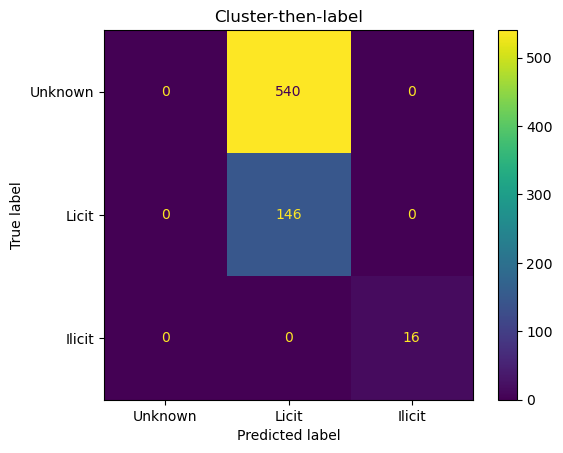

In [71]:
ctl.test()

In [23]:
for i in range(10):
    if i>=6:
        break

print(i)

6


In [26]:
len(np.array([-1 for i, label in enumerate(ctl.y)]))# if i in ctl.test_indices])

3506

In [99]:
a = {'0':[1]*64, '1':[34]*64, '2':[24]*64}
a = pd.DataFrame(a)

In [32]:
x = np.array([0,1,2,3,4,5,6,7,8,9])
yy = np.array([0,0,0,-1,0,1,1,1,-1,-1])
zz = np.array([0,0,0,-1,0,0,1,1,0,-1])

cm = confusion_matrix(yy,zz)
cm
# x1, x2, yy1, yy2 = train_test_split(x, yy, test_size=0.2)

array([[2, 1, 0],
       [0, 4, 0],
       [0, 1, 2]], dtype=int64)